# RNN 실행계획

1. input : 요일, 공휴일 유무를 집어넣는다.
2. 점심(한식), 점심(양식)을 따로 예측한다. 
3. 예측치 , 실측치 차이가 큰 지점을 살펴본다.
    - 메뉴를 통해서 그 차이를 보정할 수 있는지 돌려본다.
    - 메뉴는 주메뉴 그중에서 육류, 튀김, 생선 등등 이런걸 쓰고 예측치-실측치 차이를 regression한다. 
    - (예상결과) : 각 메뉴의 중요도를 살필 수 있ㄷ을거같다. 
    
4. 여유가 생기면 

In [17]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import os
import shutil
from mpl_toolkits.mplot3d import Axes3D
from six.moves import cPickle

import pandas as pd

from sklearn.preprocessing import OneHotEncoder

from RNN import RNNmodel

# intervalDay 7일 버전

In [11]:
from six.moves import cPickle
intervalDay = 7 
df_X7 = cPickle.load(open('./trainData{}.pkl'.format(intervalDay), 'rb'))
df_Y7 = cPickle.load(open('./validDate{}.pkl'.format(intervalDay), 'rb'))

In [31]:
trainWindow = []
# Train은 우선 바로앞만 예측하는걸로 학습
for orderIndex in df_X7.orderDf.unique():
    tempArray = df_X7[df_X7.orderDf == orderIndex][['date','values_kor','values_west','weekday','holiday']].values
    for i in range(len(tempArray)-(intervalDay+3)):
        trainWindow.append(tempArray[i:i+intervalDay+3])
        

In [103]:
validWindow = []
for orderIndex in df_Y7.orderDf.unique():
    tempArray = df_Y7[df_Y7.orderDf == orderIndex][['date','values_kor','values_west','weekday','holiday']].values
    validWindow.append(tempArray)        
        
trainArray = np.array(trainWindow)
validArray = np.array(validWindow)

# 예측결과를 어떻게 분석하는가?

- 일단 plot 하는걸 3일 맞추는거 말고도 특정 기간예측결과본 가지고와서 (for문 돌려서 3번째 날짜 쭉 맞추게해서) 경향을 맞추는지 살펴본다.
- total, 서양, 한식 이 세가지 에 대해서 바로위에서 한게 잘 맞는지 살펴본다,

- 위 두가지 하고난 후에야 학습때 사용되지않은 3일을 맞춰본다. 
- input 형태를 어떻게 할지 고민한다. (현재방식 뭔가 찝집함)

- 별개로 메뉴를 활용할 방안을 살펴본다. (메뉴를 보는건 더이상 time 축을 고려하지 않아도 된다고 할 수 있다)

In [84]:

#enc = OneHotEncoder(n_values=7)
#trainArrayOhe = enc.fit_transform(trainArray[:, :, 1]).toarray().reshape(-1, 31, 7)*trainArray[:, :, [0]]
#validArrayOhe = enc.fit_transform(validArray[:, :, 2]).toarray().reshape(-1, 33, 7)

rnn_config = {
    'ID': 'posco_model',
    'rnn_ID' : 'RNNmodel_{}day'.format(intervalDay),
    'n_batch' : 200,
    'n_save' : 1000,
    'n_prt' : 1000,
    'n_iter' : 10000,
    'LR' : 0.0001,
    'n_history' : 100,
    'n_input' : 4,
    'n_step' : 7,
    'n_output' : 2,
}


try: 
    os.mkdir('./{}'.format(rnn_config['ID']))
except FileExistsError:
    pass

my_model = RNNmodel(rnn_config)



trainX = trainArray[:, :intervalDay, 1:]
trainY = trainArray[:, intervalDay, 1:3]

my_model.fit(trainX, trainY)

[FileExistsError] Will you remove directory? [Y/N] Y
Model ID : posco_model
Model saved at : ./posco_model/RNNmodel_7day
999/10001Your loss (1000/10000) : 58.08481979370117
INFO:tensorflow:./posco_model/RNNmodel_7day/checkpoint/RNNmodel_7day_1000 is not in all_model_checkpoint_paths. Manually adding it.
1999/10001Your loss (2000/10000) : 30.326051712036133
INFO:tensorflow:./posco_model/RNNmodel_7day/checkpoint/RNNmodel_7day_2000 is not in all_model_checkpoint_paths. Manually adding it.
2999/10001Your loss (3000/10000) : 32.19157791137695
INFO:tensorflow:./posco_model/RNNmodel_7day/checkpoint/RNNmodel_7day_3000 is not in all_model_checkpoint_paths. Manually adding it.
3999/10001Your loss (4000/10000) : 24.28644561767578
INFO:tensorflow:./posco_model/RNNmodel_7day/checkpoint/RNNmodel_7day_4000 is not in all_model_checkpoint_paths. Manually adding it.
4999/10001Your loss (5000/10000) : 26.4666748046875
INFO:tensorflow:./posco_model/RNNmodel_7day/checkpoint/RNNmodel_7day_5000 is not in all

In [85]:
my_model.load('./posco_model/RNNmodel_7day/checkpoint/RNNmodel_7day_7000')


# Predict 1개 하는경우
trainX = trainArray[:, :intervalDay, 1:]
trainY = trainArray[:, intervalDay, 1:3]

INFO:tensorflow:Restoring parameters from ./posco_model/RNNmodel_7day/checkpoint/RNNmodel_7day_7000
Model loaded from file : ./posco_model/RNNmodel_7day/checkpoint/RNNmodel_7day_7000


In [114]:
firstInput = validArray[:, :intervalDay, 1:].copy()
validPeopleTrue = validArray[:, intervalDay, 1:3]

firstResult = my_model.predict(firstInput)

In [115]:
secondInput = validArray[:, 1:intervalDay+1, 1:].copy()
secondInput[:, -1, 1:3] = firstResult
secondResult = my_model.predict(secondInput)

In [116]:
thirdInput = validArray[:, 2:intervalDay+2, 1:].copy()
thirdInput[:, -1, 1:3] = secondResult
thirdResult = my_model.predict(thirdInput)

In [117]:
print (np.sqrt(np.mean(np.square(thirdResult[:,0] - validPeopleTrue[:,0]))))
print (np.sqrt(np.mean(np.square(thirdResult[:,1] - validPeopleTrue[:,1]))))

13.01456346235515
6.261255731661882


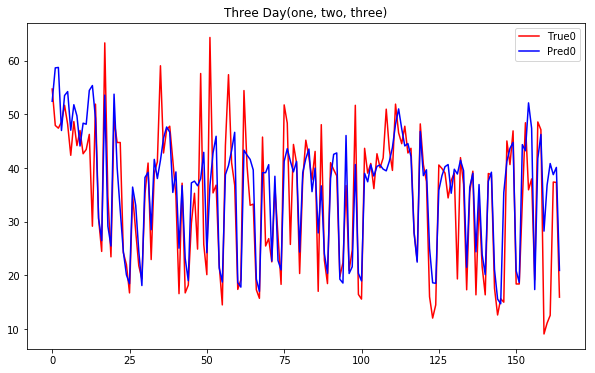

In [121]:
pred_dates = validArray[:, intervalDay:, 0].reshape(-1, 1)
trueResult0 = validArray[:, intervalDay:, 1].reshape(-1, 1)
trueResult1 = validArray[:, intervalDay:, 2].reshape(-1, 1)

predResult1 = np.concatenate([firstResult[:, [1]], secondResult[:, [1]], thirdResult[:, [1]]], 1).reshape(-1, 1)
predResult0 = np.concatenate([firstResult[:, [0]], secondResult[:, [0]], thirdResult[:, [0]]], 1).reshape(-1, 1)

plt.figure(figsize=(10, 6))
plt.title('Three Day(one, two, three)')
plt.plot(trueResult0+trueResult1, 'r', label='True0')
plt.plot(predResult0+predResult1, 'b', label='Pred0')
plt.legend()
plt.show()

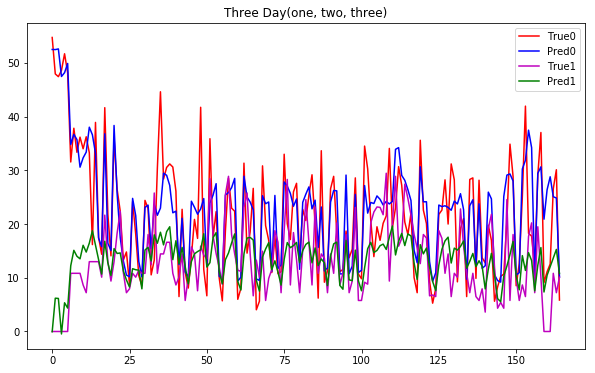

In [120]:
pred_dates = validArray[:, intervalDay:, 0].reshape(-1, 1)
trueResult0 = validArray[:, intervalDay:, 1].reshape(-1, 1)
trueResult1 = validArray[:, intervalDay:, 2].reshape(-1, 1)

predResult1 = np.concatenate([firstResult[:, [1]], secondResult[:, [1]], thirdResult[:, [1]]], 1).reshape(-1, 1)
predResult0 = np.concatenate([firstResult[:, [0]], secondResult[:, [0]], thirdResult[:, [0]]], 1).reshape(-1, 1)

plt.figure(figsize=(10, 6))
plt.title('Three Day(one, two, three)')
plt.plot(trueResult0, 'r', label='True0')
plt.plot(predResult0, 'b', label='Pred0')
plt.legend()
#plt.xticks(np.arange(0, 48*3), pred_dates.astype('datetime64[M]').reshape(-1), rotation='vertical')
#plt.savefig('threeday.png')
#plt.show()

#plt.figure(figsize=(10, 6))
#plt.title('Three Day(one, two, three)')
plt.plot(trueResult1, 'm', label='True1')
plt.plot(predResult1, 'g', label='Pred1')
plt.legend()
#plt.xticks(np.arange(0, 48*3), pred_dates.astype('datetime64[M]').reshape(-1), rotation='vertical')
#plt.savefig('threeday.png')
plt.show()